In [72]:
%load_ext griblib.jupyter

from pathlib import Path
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import xarray as xr
import dask


DATA = Path.cwd().parent / "data"
PS_STORE = DATA / "PROBSEVERE"
GMGSI_STORE = DATA / "GMGSI"

The griblib.jupyter extension is already loaded. To reload it, use:
  %reload_ext griblib.jupyter


In [73]:
MRMS_BOUNDS = [20, 55, -130, -60]
S, N, W, E = MRMS_BOUNDS
ref_time = datetime.fromisoformat("2022-07-01")


def mask_time(ds: xr.Dataset):
    times = pd.to_datetime(ds["time"].to_numpy())
    mask = (
        (times.year == ref_time.year)
        & (times.month == ref_time.month)
        & (times.day == ref_time.day)
        & (times.hour > 12)
        & (times.hour < 18)
    )
    return ds.sel({"time": mask})


gmgsi = mask_time(xr.open_zarr(GMGSI_STORE))
gmgsi = gmgsi.sel(
    {
        "lat": (gmgsi.lat > S) & (gmgsi.lat < N),
        "lon": (gmgsi.lon > W) & (gmgsi.lon < E),
    }
)
probsevere = mask_time(xr.open_zarr(PS_STORE))

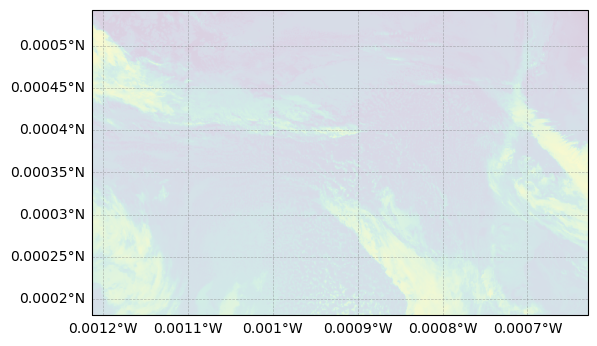

In [143]:
idx = pd.IndexSlice
ONE_HOUR = "1H"
SWP = [
    "CAPE_M10M30",
    "EBSHEAR",
    "FLASH_DENSITY",
    "FLASH_RATE",
    "LJA",
    "MAXLLAZ",
    "MEANWIND_1-3kmAGL",
    "MESH",
    "MLCAPE",
    "MLCIN",
    "MOTION_EAST",
    "MOTION_SOUTH",
    "MUCAPE",
    "P98LLAZ",
    "P98MLAZ",
    "PS",
    "PWAT",
    "SIZE",
    "SRH01KM",
    "VIL_DENSITY",
    "WETBULB_0C_HGT",
]
metsat = gmgsi.to_dataframe().reset_index()  # .reset_index()
metsat["lat"] = metsat["lat"].round(2)
metsat["lon"] = metsat["lon"].round(2)
metsat = metsat.set_index(["time", "lat", "lon"])
# metsat["lat"] = metsat["lat"].round(2)
lat, lon = (metsat.index.unique(key).values.round(2) for key in ("lat", "lon"))
df = probsevere.to_dataframe()
from numpy.typing import NDArray


def index_min(target: NDArray, values: NDArray) -> NDArray:

    diff = values - target[:, np.newaxis]
    index = np.argmin(abs(diff), axis=0)
    result = target[index]
    return result


df["lat"] = index_min(lat, df["X"].values)  # .shape, df["X"].shape
df["lon"] = index_min(lon, df["Y"].values)

df = (
    df.reset_index()
    .groupby([pd.Grouper(key="time", freq=ONE_HOUR, origin="epoch"), "lat", "lon"])[["PS"]]
    .max()
    # .reset_index()
)

# df.lat


metsat
f = pd.DataFrame(np.full((len(metsat.index), len(df.columns)), np.nan), index=metsat.index, columns=df.columns)

f.loc[df.index] = df

f["SAT"] = metsat

f = f.loc["2022-07-01 13:00:00"]  # .unstack("lon")

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

ax: GeoAxes = plt.axes(projection=ccrs.Mercator())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color="gray", alpha=0.5, linestyle="--")
gl.top_labels = False
gl.right_labels = False
# ax.set_title(label.astype("datetime64[m]"))
ax.coastlines(resolution="auto")
# ax.imshow(arr, extent=tuple(extent))
ax.imshow(f["SAT"].unstack("lon"), extent=(-135, -70, 20, 60), alpha=0.2)
ax.imshow(f["PS"].unstack("lon"), extent=(-135, -70, 20, 60))
ax.coastlines(resolution="auto")
# f["SAT"].reset_
# f.reset_index().plot.scatter(x="lon", y="lat", c="PS", cmap="jet", ax=ax)
# plt.imshow(f)
# f.notna().any().any()
# f[f.notna()]
# df.max()
#

In [3]:
from typing import Hashable
import dask.dataframe as dd
import dask.array as da
from numpy.typing import NDArray


class DaskFrame:
    @property
    def values(self) -> da.Array:
        ...


class DaskSeries(dd.Series):
    @property
    def values(self) -> da.Array:
        ...


class DaskDataFrame(dd.DataFrame):
    @property
    def values(self) -> da.Array:
        ...

    def __getitem__(self, key: Hashable) -> DaskSeries:
        ...

    def __getitem__(self, key: list[Hashable]) -> "DaskDataFrame":
        ...

    # return super().__getitem__(key)


# dd.Series
_15MIN = "15T"
_1HOUR = "1H"
gmgsi_df = gmgsi.to_dask_dataframe()  # .set_index("time")
lat, lon = (gmgsi[key].values.astype(np.float32) for key in ("lat", "lon"))
# gmgsi_df["lat"] = lat
# gmgsi_df["lon"] = lon
# dd.from_array(lon)
SWP = [
    "CAPE_M10M30",
    "EBSHEAR",
    "FLASH_DENSITY",
    "FLASH_RATE",
    "LJA",
    "MAXLLAZ",
    "MEANWIND_1-3kmAGL",
    "MESH",
    "MLCAPE",
    "MLCIN",
    "MOTION_EAST",
    "MOTION_SOUTH",
    "MUCAPE",
    "P98LLAZ",
    "P98MLAZ",
    "PS",
    "PWAT",
    "SIZE",
    "SRH01KM",
    "VIL_DENSITY",
    "WETBULB_0C_HGT",
]


def old():
    ps = probsevere.copy().to_dataframe()  # .to_dataframe()
    gmgsi_df["lat"] = dd.from_array(lat)
    gmgsi_df["lon"] = dd.from_array(lon)
    ps["lat"] = gmgsi_df.loc[np.argmin(abs(lat[:, np.newaxis] - ps["X"].to_numpy()), axis=0), "lat"]
    ps["lon"] = gmgsi_df.loc[np.argmin(abs(lon[:, np.newaxis] - ps["Y"].to_numpy()), axis=0), "lon"]

    # [np.argmin(abs(lat[:, np.newaxis] - ps["X"].to_numpy()), axis=0)]
    # == lat
    ps = (
        ps.astype(np.float32)
        .reset_index()
        .groupby([pd.Grouper(key="time", freq=_1HOUR, origin="epoch"), "lat", "lon"])[SWP]
        .mean()
        .reset_index(["lat", "lon"])
    )

    # gmgsi_df
    # ps
    return (
        ps["lat"].values[:, np.newaxis] == gmgsi_df.lat.values
    )  # .compute()  # dd.concat([gmgsi_df.set_index("time"), ps])
    # ddf: DaskDataFrame = dd.concat([gmgsi_df.set_index("time"), ps])  # .astype(np.float32)


ps = probsevere.copy().to_dataframe()  # .to_dataframe()
# gmgsi_df["lat"] = dd.from_array(lat)
# gmgsi_df["lon"] = dd.from_array(lon)
gmgsi_df = gmgsi.to_dataframe()
lat, lon = (gmgsi_df.index.unique(key).to_numpy().astype(float) for key in ("lat", "lon"))
ps["lat"] = lat[np.argmin(abs(lat[:, np.newaxis] - ps["X"].to_numpy()), axis=0)]
ps["lon"] = lon[np.argmin(abs(lon[:, np.newaxis] - ps["Y"].to_numpy()), axis=0)]
ps = (
    ps.astype(np.float32)
    .reset_index()
    .groupby([pd.Grouper(key="time", freq=_1HOUR, origin="epoch"), "lat", "lon"])[SWP]
    .mean()
    .reset_index(["lat", "lon"])
)
# len(lat)
idx = pd.IndexSlice
mask = np.any(ps["lat"].to_numpy() == lat[:, np.newaxis], axis=0) & np.any(
    ps["lon"].to_numpy() == lon[:, np.newaxis], axis=0
)
# lat[np.any(ps["lat"].to_numpy() == lat[:, np.newaxis], axis=1)]

# (
#     np.any(ps["lat"].to_numpy() == lat[:, np.newaxis], axis=1)
#     & np.any(ps["lon"].to_numpy() == lon[:, np.newaxis], axis=1)[:, np.newaxis]
# ).shape
ps["GMGSI_LW"] = None
pd.concat(
    [
        gmgsi_df.loc[
            idx[
                :,
                lat[np.any(ps["lat"].to_numpy() == lat[:, np.newaxis], axis=1)],
                lon[np.any(ps["lon"].to_numpy() == lon[:, np.newaxis], axis=1)],
            ],
            :,
        ].reset_index(),
        ps[["PS", "lat", "lon", "GMGSI_LW"]].reset_index(),
    ]
).set_index(
    ["time", "lat", "lon"]
)  # .dropna(axis=1, how="any")
# gmgsi_df.reset_index()
# crds["lat"].values[np.argmin(abs(crds.lat.values[:, np.newaxis] - ps["X"].to_numpy()), axis=0)]
# ps["lat"] = gmgsi_df.loc[np.argmin(abs(crds.lat.values[:, np.newaxis] - ps["X"].to_numpy()), axis=0), "lat"]
# ps["lon"] = gmgsi_df.loc[np.argmin(abs(lon[:, np.newaxis] - ps["Y"].to_numpy()), axis=0), "lon"]
# probsevere["lat"]
# ddf = old()
# ddf


# gmg = gmgsi_df.reset_index()

GMGSI_LW   PS
time                lat       lon                       
2022-03-01 13:00:00 25.861633 -124.625496      76.0  NaN
                              -121.889160      73.0  NaN
                              -121.745140      73.0  NaN
                              -121.673134      75.0  NaN
                              -121.601120      74.0  NaN
...                                             ...  ...
2022-03-01 17:00:00 42.115784 -71.554901        NaN  0.0
                    47.911606 -71.122841        NaN  0.0
                              -71.050835        NaN  0.0
                              -70.978828        NaN  0.0
                    48.152374 -70.762802        NaN  0.0

[25984 rows x 2 columns]

In [4]:
ps2 = ps.copy().reset_index()
gm2 = gmgsi_df.copy().reset_index()
lat_case = np.argmin(abs(ps2["lat"].values - gm2["lat"].values[:, np.newaxis]), axis=0)
lon_case = np.argmin(abs(ps2["lon"].values - gm2["lon"].values[:, np.newaxis]), axis=0)

ps2["GMGSI_LW"] = gm2.loc[lat_case & lon_case, "GMGSI_LW"].to_numpy()

ps2.set_index(["time", "lat", "lon"])

CAPE_M10M30    EBSHEAR  \
time                lat       lon                                  
2022-03-01 13:00:00 25.926407 -78.467758     0.000000  11.400000   
                    26.120537 -79.043831     0.000000  26.600000   
                    26.185165 -79.259857     2.500000  23.350000   
                              -79.043831     2.444444  27.955555   
                              -78.683784     0.800000  22.680000   
...                                               ...        ...   
2022-03-01 17:00:00 42.115784 -71.554901     0.000000   0.000000   
                    47.911606 -71.122841     0.000000   0.000000   
                              -71.050835     0.000000   0.000000   
                              -70.978828     0.000000   0.000000   
                    48.152374 -70.762802     0.000000   0.000000   

                                          FLASH_DENSITY  FLASH_RATE  LJA  \
time                lat       lon                                          
2022-03-01 13:00:00 25.926407 -78.467758            0.0         0.0  0.0   
                    26.120537 -79.043831            0.0         0.0  0.0   
                    26.185165 -79.259857            0.0         0.0  0.0   
                              -79.043831            0.0         0.0  0.0   
                              -78.683784            0.0         0.0  0.0   
...                                                 ...         ...  ...   
2022-03-01 17:00:00 42.115784 -71.554901            0.0         0.0  0.0   
                    47.911606 -71.122841            0.0         0.0  0.0   
                              -71.050835            0.0         0.0  0.0   
                              -70.978828            0.0         0.0  0.0   
                    48.152374 -70.762802            0.0         0.0  0.0   

                                          MAXLLAZ  MEANWIND_1-3kmAGL  \
time                lat       lon                                      
2022-03-01 13:00:00 25.926407 -78.467758   0.0020          13.400000   
                    26.120537 -79.043831   0.0010          12.500000   
                    26.185165 -79.259857   0.0010          11.100000   
                              -79.043831   0.0010          12.222222   
                              -78.683784   0.0015          13.300000   
...                                           ...                ...   
2022-03-01 17:00:00 42.115784 -71.554901   0.0000          30.700001   
                    47.911606 -71.122841   0.0000          23.400000   
                              -71.050835   0.0000          23.700001   
                              -70.978828   0.0000          23.633333   
                    48.152374 -70.762802   0.0000          19.500000   

                                              MESH      MLCAPE       MLCIN  \
time                lat       lon                                            
2022-03-01 13:00:00 25.926407 -78.467758  0.000000  234.000000   -4.000000   
                    26.120537 -79.043831  0.000000  387.000000   -1.000000   
                    26.185165 -79.259857  0.060000  399.500000   -1.000000   
                              -79.043831  0.000000  410.555542   -1.222222   
                              -78.683784  0.098000  359.299988   -3.000000   
...                                            ...         ...         ...   
2022-03-01 17:00:00 42.115784 -71.554901  0.000000    0.000000 -999.000000   
                    47.911606 -71.122841  0.250000    0.000000 -999.000000   
                              -71.050835  0.410000    0.000000 -999.000000   
                              -70.978828  0.091111    0.000000 -999.000000   
                    48.152374 -70.762802  0.530000    0.000000 -999.000000   

                                          ...      MUCAPE  P98LLAZ   P98MLAZ  \
time                lat       lon         ...                                  
2022-03-01 13:00:00 25.926407 -78.467758  ...  361.33334

In [46]:
ps3 = ps.copy().reset_index().round(2)
gm3 = gmgsi_df.copy().reset_index().round(2)

# lat_diff = abs(ps3["lat"].values[:, np.newaxis] - gm3["lat"].values)
# lat_values = gm3["lat"].values[np.argmin(lat_diff, axis=1)]

# lon_diff = abs(ps3["lon"].values[:, np.newaxis] - gm3["lon"].values)
# lon_values = gm3["lon"].values[np.argmin(lon_diff, axis=1)]
# lon_values


# def fit_array(target: NDArray, values: NDArray) -> NDArray:
#     # target = getattr(self, {"x": "longitudes", "y": "latitudes"}[axis.lower()])
#     return target[np.argmin(abs(target - values[:, np.newaxis]), axis=1)]


def diffmin(target: NDArray, values: NDArray) -> NDArray:
    """
    determines the nearest grid line in a given axis for an array
    calculates the distance along that axis to the nearest line
    """
    return np.argmin(abs(target - values), axis=1)


def fit_array(target: NDArray, values: NDArray) -> NDArray:
    """
    determines the nearest grid line in a given axis for an array
    calculates the distance along that axis to the nearest line
    """
    # if axis not in ("X", "Y"):
    #     raise Exception

    # target = self.longitudes if axis == "X" else self.latitudes

    min_diff = diffmin(target, values[:, np.newaxis])

    return target[min_diff]

    next_line = target[min_diff + 1]

    return near_line, self.delta_a2b(near_line, next_line, axis=axis)


ps3["lat"] = fit_array(
    gm3.lon.values,
    ps3.lon.values,
)  # .round(2)
ps3["lon"] = fit_array(
    gm3.lat.values,
    ps3.lat.values,
)  # .round(2)
gm3["lat"].isin(ps3["lat"]).any()
# gm3.groupby(
#     [ps3.lat.values, ps3.lon.values]
# )  # .set_index(["time", "lat", "lon"]).loc[idx[:, ps3.lat.values, ps3.lon.values], :]
# ps3.lat
# np.array(np.meshgrid(ps3.lon.values, ps3.lat.values)).T

: 

: 

In [74]:
ps3

,time,lat,lon,CAPE_M10M30,EBSHEAR,FLASH_DENSITY,FLASH_RATE,LJA,MAXLLAZ,MEANWIND_1-3kmAGL,...,MUCAPE,P98LLAZ,P98MLAZ,PS,PWAT,SIZE,SRH01KM,VIL_DENSITY,WETBULB_0C_HGT,GMGSI_LW
0,2022-03-01 13:00:00,25.926407,-78.467758,0.000000,11.400000,0.0,0.0,0.0,0.0020,13.400000,...,361.333344,0.0010,0.001000,0.0,1.0,61.666668,11.000000,0.416667,9.300000,None
1,2022-03-01 13:00:00,26.120537,-79.043831,0.000000,26.600000,0.0,0.0,0.0,0.0010,12.500000,...,559.000000,0.0010,0.001000,1.0,1.1,53.000000,12.000000,0.730000,9.300000,None
2,2022-03-01 13:00:00,26.185165,-79.259857,2.500000,23.350000,0.0,0.0,0.0,0.0010,11.100000,...,653.000000,0.0010,0.001000,1.0,1.1,66.000000,5.000000,1.270000,8.900000,None
3,2022-03-01 13:00:00,26.185165,-79.043831,2.444444,27.955555,0.0,0.0,0.0,0.0010,12.222222,...,616.222229,0.0010,0.000778,1.0,1.1,61.111111,12.222222,0.498889,9.300000,None
4,2022-03-01 13:00:00,26.185165,-78.683784,0.800000,22.680000,0.0,0.0,0.0,0.0015,13.300000,...,534.000000,0.0013,0.001100,0.7,1.2,66.800003,22.000000,0.860000,9.300000,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2022-03-01 17:00:00,42.115784,-71.554901,0.000000,0.000000,0.0,0.0,0.0,0.0000,30.700001,...,0.000000,0.0000,0.000000,0.0,0.4,72.000000,169.750000,0.270000,0.200000,None
140,2022-03-01 17:00:00,47.911606,-71.122841,0.000000,0.000000,0.0,0.0,0.0,0.0000,23.400000,...,0.000000,0.0000,0.000000,0.0,0.1,131.199997,115.000000,1.310000,0.300000,None
141,2022-03-01 17:00:00,47.911606,-71.050835,0.000000,0.000000,0.0,0.0,0.0,0.0000,23.700001,...,0.000000,0.0000,0.000000,0.0,0.1,53.000000,117.000000,1.590000,0.300000,None
142,2022-03-01 17:00:00,47.911606,-70.978828,0.000000,0.000000,0.0,0.0,0.0,0.0000,23.633333,...,0.000000,0.0000,0.000000,0.0,0.1,41.111111,116.444443,0.353333,0.355556,None


In [40]:
df = ddf.compute()
df
# df.set_index(["lat", "lon"], append=True)
# df
# ddf.repartition(npartitions=ddf.npartitions // 100)
# type(ddf)
# dir(ddf)

,lat,lon,GMGSI_LW,CAPE_M10M30,EBSHEAR,FLASH_DENSITY,FLASH_RATE,LJA,MAXLLAZ,MEANWIND_1-3kmAGL,...,MOTION_SOUTH,MUCAPE,P98LLAZ,P98MLAZ,PS,PWAT,SIZE,SRH01KM,VIL_DENSITY,WETBULB_0C_HGT
time,,,,,,,,,,,,,,,,,,,,,
2022-03-01 00:00:00,20.029663,-129.954163,72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:00:00,20.097298,-129.882156,72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:00:00,20.164909,-129.810150,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:00:00,20.232491,-129.738129,72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:00:00,20.300041,-129.666122,72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-01 23:00:00,45.593292,-81.924187,NaN,3.0,29.200001,0.0,0.0,0.0,0.0035,34.549999,...,0.8935,241.0,0.003,0.002,1.0,0.7,47.0,87.5,0.62,5.0
2022-03-01 23:00:00,45.593292,-81.564140,NaN,8.0,30.500000,0.0,0.0,0.0,0.0040,33.599998,...,0.7260,279.0,0.003,0.002,1.0,0.8,41.0,85.0,0.61,5.3
2022-03-01 23:00:00,45.593292,-81.492134,NaN,3.0,29.100000,0.0,0.0,0.0,0.0040,34.599998,...,-0.4530,238.0,0.003,0.002,1.0,0.7,44.0,87.0,0.63,5.0


In [48]:
df: pd.DataFrame = df
df  # .groupby(["time", "lat", "lon"]).any()

,lat,lon,GMGSI_LW,CAPE_M10M30,EBSHEAR,FLASH_DENSITY,FLASH_RATE,LJA,MAXLLAZ,MEANWIND_1-3kmAGL,...,MOTION_SOUTH,MUCAPE,P98LLAZ,P98MLAZ,PS,PWAT,SIZE,SRH01KM,VIL_DENSITY,WETBULB_0C_HGT
time,,,,,,,,,,,,,,,,,,,,,
2022-03-01 00:00:00,20.029663,-129.954163,72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:00:00,20.097298,-129.882156,72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:00:00,20.164909,-129.810150,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:00:00,20.232491,-129.738129,72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:00:00,20.300041,-129.666122,72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-01 03:00:00,47.426697,27.342445,NaN,0.0,11.3,0.0,0.0,0.0,0.001,41.700001,...,-1.926,42.0,0.001,0.001,0.0,0.9,337.0,214.0,0.50,6.1
2022-03-01 03:00:00,47.426697,30.120323,NaN,0.0,11.3,0.0,0.0,0.0,0.001,41.700001,...,-1.352,42.0,0.001,0.001,0.0,0.9,337.0,214.0,0.50,6.1
2022-03-01 03:00:00,47.426697,41.147003,NaN,0.0,13.1,0.0,0.0,0.0,0.001,41.500000,...,-4.592,48.0,0.001,0.001,0.0,0.9,484.0,213.0,0.54,6.2


In [6]:
df.lat
# df.loc[df.lat == 20.029663]  # .loc[41.147003,:]

0                      20.029663
1                      20.029663
2                      20.029663
3                      20.029663
4                      20.029663
                         ...    
2022-03-01 23:00:00    41.147003
2022-03-01 23:00:00    41.147003
2022-03-01 23:00:00    44.576462
2022-03-01 23:00:00    45.593292
2022-03-01 23:00:00    47.766617
Name: lat, Length: 14814953, dtype: float32

In [14]:
import dask.dataframe as dd

lat, lon = (gmgsi[key].to_numpy() for key in ("lat", "lon"))
_15MIN = "15T"
_1HOUR = "1H"
ps = probsevere.copy().to_dataframe()
# gmgsi
ps["lat"] = lat[np.argmin(abs(lat[:, np.newaxis] - ps["X"].to_numpy()), axis=0)]
ps["lon"] = lon[np.argmin(abs(lon[:, np.newaxis] - ps["Y"].to_numpy()), axis=0)]
SWP = [
    "CAPE_M10M30",
    "EBSHEAR",
    "FLASH_DENSITY",
    "FLASH_RATE",
    "LJA",
    "MAXLLAZ",
    "MEANWIND_1-3kmAGL",
    "MESH",
    "MLCAPE",
    "MLCIN",
    "MOTION_EAST",
    "MOTION_SOUTH",
    "MUCAPE",
    "P98LLAZ",
    "P98MLAZ",
    "PS",
    "PWAT",
    "SIZE",
    "SRH01KM",
    "VIL_DENSITY",
    "WETBULB_0C_HGT",
]
mean_swp = (
    ps.astype(np.float32)
    .reset_index()
    .groupby([pd.Grouper(key="time", freq=_1HOUR, origin="epoch"), "lat", "lon"])[SWP]
    .mean()
)


ddf = dd.concat([mean_swp.reset_index(), gmgsi.to_dataframe().reset_index()])
ddf

AttributeError: 'Series' object has no attribute 'to_numpy'

In [5]:

gmgsi = xr.open_zarr(GMGSI_STORE)
ps = xr.open_zarr(PS_STORE).to_dataframe()

lat, lon = (gmgsi[key].to_numpy() for key in ("lat", "lon"))
_15MIN = "15T"
_1HOUR = "1H"
# gmgsi
ps["LAT"] = lat[np.argmin(abs(lat[:, np.newaxis] - ps["X"].to_numpy()), axis=0)]
ps["LON"] = lon[np.argmin(abs(lon[:, np.newaxis] - ps["Y"].to_numpy()), axis=0)]
SWP = [
    "CAPE_M10M30",
    "EBSHEAR",
    "FLASH_DENSITY",
    "FLASH_RATE",
    "LJA",
    "MAXLLAZ",
    "MEANWIND_1-3kmAGL",
    "MESH",
    "MLCAPE",
    "MLCIN",
    "MOTION_EAST",
    "MOTION_SOUTH",
    "MUCAPE",
    "P98LLAZ",
    "P98MLAZ",
    "PS",
    "PWAT",
    "SIZE",
    "SRH01KM",
    "VIL_DENSITY",
    "WETBULB_0C_HGT",
]
# ps.reset_index().groupby([pd.Grouper(key="time", freq="15T", origin="epoch"), "X", "Y", "ID"]).mean()
# tuple(ps.reset_index().groupby([pd.Grouper(key="time", freq="15T", origin="epoch"), "X", "Y"]))
# len(tuple(ps.groupby([ps.index.year, ps.index.month, ps.index.day, ps.index.hour])))
mean_swp = ps.reset_index().groupby([pd.Grouper(key="time", freq=_1HOUR, origin="epoch"), "LAT", "LON"])[SWP].mean()
mean_swp

TypeError: reset_index() missing 1 required positional argument: 'dims_or_levels'

In [12]:
mean_swp.index.unique("time").to_numpy()
ps = xr.open_zarr(PS_STORE).to_dataframe()
ps
# gmgsi["time"].to_numpy()  # == mean_swp.index.unique("time")  # .sel({"time": mean_swp.index.unique("time")})

,CAPE_M10M30,EBSHEAR,FLASH_DENSITY,FLASH_RATE,ID,LJA,MAXLLAZ,MAXX,MAXY,MEANWIND_1-3kmAGL,...,P98LLAZ,P98MLAZ,PS,PWAT,SIZE,SRH01KM,VIL_DENSITY,WETBULB_0C_HGT,X,Y
time,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:38,207,49.700001,0.02,0,20964,0.0,0.005,-83.879997,34.730000,36.799999,...,0.004,0.004,8,1.4,306,200,0.79,9.1,34.639999,-83.972504
2022-01-01 00:00:38,187,43.700001,0.00,0,21312,0.0,0.004,-110.470001,32.799999,34.500000,...,0.003,0.003,3,0.7,128,85,0.37,4.2,32.709999,-110.526001
2022-01-01 00:00:38,0,0.000000,0.00,0,21320,0.0,0.000,-71.029999,47.990002,31.200001,...,0.000,0.000,0,0.3,68,168,0.94,0.4,47.935001,-71.165001
2022-01-01 00:00:38,169,43.200001,0.00,0,21323,0.0,0.001,-110.320000,32.939999,35.099998,...,0.001,0.001,3,0.7,135,84,0.41,3.5,32.884998,-110.385002
2022-01-01 00:00:38,0,0.000000,0.00,0,21324,0.0,0.000,-95.980003,39.849998,35.500000,...,0.000,0.000,0,0.4,69,150,0.51,0.3,39.810001,-96.019997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01 23:58:38,0,27.000000,0.00,0,28342,0.0,0.001,-88.330002,36.230000,27.500000,...,0.001,0.001,0,1.4,45,0,0.38,11.3,36.209999,-88.366669
2022-01-01 23:58:38,41,59.299999,0.00,0,28343,0.0,0.004,-85.620003,35.849998,50.700001,...,0.004,0.006,4,1.6,49,170,1.01,10.9,35.825001,-85.654999
2022-01-01 23:58:38,85,61.799999,0.00,0,28344,0.0,0.013,-85.669998,35.619999,52.799999,...,0.012,0.005,6,1.6,43,289,1.21,10.0,35.584999,-85.702499


In [69]:
ps.columns.tolist()

['CAPE_M10M30',
 'EBSHEAR',
 'FLASH_DENSITY',
 'FLASH_RATE',
 'ID',
 'LJA',
 'MAXLLAZ',
 'MAXX',
 'MAXY',
 'MEANWIND_1-3kmAGL',
 'MESH',
 'MINX',
 'MINY',
 'MLCAPE',
 'MLCIN',
 'MOTION_EAST',
 'MOTION_SOUTH',
 'MUCAPE',
 'P98LLAZ',
 'P98MLAZ',
 'PS',
 'PWAT',
 'SIZE',
 'SRH01KM',
 'VIL_DENSITY',
 'WETBULB_0C_HGT',
 'X',
 'Y',
 'LAT',
 'LON']